In [1]:
#%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.model_selection import train_test_split
from scipy.fftpack import fft, fftfreq
from scipy import signal
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
import h5py
from simple_edf_preprocessing import Preprocessor

In [2]:
# #create a ECOG PCA class for its PCA object, hyperparas and other stuff
# class PCA_Ecog:
#     def __init__(self, raw=None, pca_obj=None,wsize=2):
#         self.pca=pca_obj
#         self.raw=raw
#         #hyperpara in s for how large the time window should be on whihc we calculate our fourier trafo
#         self.wsize=wsize
#         #sampling frequency and last sample taken
#         if(self.raw != None):
#             self.sfreq=self.raw.info['sfreq']
#             self.end=self.raw.time_as_index(len(raw))
#         else:
#             self.sfreq=None
#             self.end=None
        
#     #load some EDF data   
#     def read_in_raw(self, fpath):
#         self.raw=mne.io.read_raw_edf(fpath)
#         #TODO exclude bad channels
#         self.sfreq=self.raw.info['sfreq']
#         self.end=self.raw.time_as_index(len(self.raw))

        
#     def demean_and_scale(self, data,ax=0):
#         self.data_mean=np.mean(data,axis=ax)
#         data_dem=data-self.data_mean
#         self.data_scal=1000000
#         data_scal=self.data_scal*data_dem
#         return data_scal
    
        
#     #create matrix as follows:
#     #columns: channels, for each channel the 200 frequencies (0-200Hz) (hece freq*cha length)
#     #rows: Time steps
#     #resulting matrix is 2D, Time Stepsx(Freq*Channels)
#     #note that this matrix is prone to constant change. Save the current data as member variable
#     def calc_data_mat(self,time_sta,time_stp):
#         if(self.raw==None):
#             raise ValueError('Raw Data not set.')
#         time_it=time_sta
#         while True:
#             #calculate times in sample points
#             start, stop = self.raw.time_as_index([time_it,time_it+self.wsize])
#             #get data of ALL channels except the Event and the stim channel, which are weird.
#             data=self.raw.get_data(picks=range(1,self.raw.info['nchan']-1),start=start,stop=stop,reject_by_annotation=None,return_times=False)
#             #welch method TODO check if this works like this
#             fr,psd=signal.welch(data,self.sfreq)
#             self.fr=fr[fr<=200]
#             #truncate everythin above 200Hz
#             psd=psd[:,fr<=200]
#             self.psd=psd
#             if time_it==time_sta:
#                 #first time. create first column, flatten w/o argument is row major 
#                 mat=psd.flatten()
#                 print('heyo',mat.shape)
#             else:
#                 #after, add column for each time step
#                 mat=np.column_stack((mat,psd.flatten()))
#             time_it+=self.wsize
#             if time_it >= time_stp+self.wsize:
#                 break
#         data_scal=self.demean_and_scale(mat.T)
#         self.curr_data=data_scal
#         return data_scal

#     def vis_raw_data(self, start, stop, chans=None):
#         if(self.raw==None):
#             raise ValueError('Raw Data not set (yet)')
#         if chans is None:
#             chans=range(1,self.raw.info['nchan'])
#         st,stp=self.raw.time_as_index([start,stop])
#         print(st,stp)
#         #TODO optimize this out
#         data=self.raw.get_data(picks=chans,start=st,stop=stp,reject_by_annotation=None,return_times=False)
#         for p in range(0,len(chans)-1):
#             plt.plot(data[p])
#         plt.show()
    
#     def vis_welch_data(self,start,stop,no_chan=None):
#         #first, remean and unscale
#         rem=self.curr_data[start:stop,:].T/self.data_scal+self.data_mean[:,np.newaxis]
#         print(self.data_mean.shape,'this is shape')
#         print('data')
#         print(self.curr_data[start:stop,4000].T)
#         plt.imshow(np.log(rem)*100000,cmap='viridis',aspect='auto')
#         print(rem.shape)
#         print(rem[4000,:])

In [2]:
#create a ECOG PCA class for its PCA object, hyperparas and other stuff
class PCA_Ecog_preprocessed:
    def __init__(self,path=None,pca_obj=None,wsize=30):
        self.pca=pca_obj
        #hyperpara in s for how large the time window should be on whihc we calculate our fourier trafo
        self.wsize=wsize
        #sampling frequency and last sample taken
        if(path != None):
            self.df=df=h5py.File(path)
            #preprocess data
            self.Preprocessor=Preprocessor(self.df)
            self.data,self.bad_chan,self.bad_idx=self.Preprocessor.preprocess()
            self.data=self.data[self.bad_chan!=True]
            self.sfreq=self.df['f_sample'][()]
            #how many samples in this dataset?
            self.end=self.data.shape[1]-1
            
        else:
            self.df=None
            self.sfreq=None
            self.end=None
        
      
    def standardize(self, data,ax=0):
        self.data_mean=np.mean(data,axis=ax)
        data_dem=data-self.data_mean
        std=np.std(data,axis=ax)
        data_stand=data_dem/std
        #self.data_scal=1000000
        #data_scal=self.data_scal*data_dem
        #return data_scal
        return data_stand
    
#this function caps at 200Hz, then bins the data in a logarithmic fashion to account for smaller psd values in higher freqs
    def bin_psd(self,fr,psd):
        fr_trun=fr[fr<=200]
        fr_total=len(fr_trun)
        fr_bins=np.arange(int(np.log2(fr_total)+1))
        #truncate everythin above 200Hz
        psd=psd[:,fr<=200]
        psd_bins=np.zeros((psd.shape[0],len(fr_bins)))
        prev=0
        max_psd_per_bin=np.exp2(fr_bins).astype('int')
        prev=0
        for b in fr_bins:
            if (b==len(fr_bins) or max_psd_per_bin[b]>=psd.shape[1]):
                psd_bins[:,b]+=np.sum(psd[:,prev:],axis=1)
            else:
                psd_bins[:,b]=np.sum(psd[:,prev:max_psd_per_bin[b]],axis=1)
            prev=max_psd_per_bin[b]
        return fr_bins, psd_bins

    
        
    #create matrix as follows:
    #columns: channels, for each channel the 200 frequencies (0-200Hz) (hece freq*cha length) BUT BINNED logarithmically
    #rows: Time steps
    #resulting matrix is 2D, Time Stepsx(Freq*Channels)
    #note that this matrix is prone to constant change. Save the current data as member variable
    def calc_data_mat(self,time_sta,time_stp):
        if(self.df==None):
            raise ValueError('Raw Data not set.')
        time_it=time_sta
        while True:
            if (time_it+pecog.wsize)*pecog.sfreq>=pecog.data.shape[1]-1:
                print('Not enough data for set end %d. Returning all data that is available in given range.'% time_stp)
                break
            #calculate times in sample points. Make use of frequency
            start=int(time_it*self.sfreq)
            stop=int((time_it+self.wsize)*self.sfreq)
            #get data of ALL channels
            curr_data=self.data[:,start:stop]
            #welch method TODO check if this works like this
            fr,psd=signal.welch(curr_data,self.sfreq)
            fr_bins,psd_bins=self.bin_psd(fr,psd)
            if time_it==time_sta:
                self.fr_bins=fr_bins
                #first time. create first column, flatten w/o argument is row major 
                mat=psd_bins.flatten()
                print('heyo',mat.shape)
            else:
                #after, add column for each time step
                mat=np.column_stack((mat,psd_bins.flatten()))
            time_it+=self.wsize
            if time_it+pecog.wsize >= time_stp:
                break
        data_scal=self.standardize(mat.T)
        self.curr_data=data_scal
        return data_scal
    
#TODO MAKE THIS APPROPRIATE
    def vis_raw_data(self, start, stop, chans=None):
        if(self.df==None):
            raise ValueError('Raw Data not set (yet)')
        if chans is None:
            chans=range(self.data.shape[0])
        st=int(start*self.sfreq)
        stp=int(stop*self.sfreq)
        data=self.data[:,st:stp]
        for p in range(0,len(chans)-1):
            plt.plot(data[p])
        plt.show()
    
    def vis_welch_data(self,start,stop,no_chan=None):
        #first, remean and unscale
        rem=self.curr_data[start:stop,:].T/self.data_scal+self.data_mean[:,np.newaxis]
        print(self.data_mean.shape,'this is shape')
        print('data')
        print(self.curr_data[start:stop,4000].T)
        plt.imshow(np.log(rem)*100000,cmap='viridis',aspect='auto')
        print(rem.shape)
        print(rem[4000,:])

        #get elbow curve
    def elbow_curve(self):
        components = range(1, self.data.shape[1] + 1)
        explained_variance = []
        for component in tqdm(components[:50]):
            pca = PCA(n_components=component)
            pca.fit(data)
            explained_variance.append(sum(pca.explained_variance_ratio_))
        sns_plot = sns.regplot(
            x=np.array(components[:50]), y=explained_variance,
            fit_reg=False).get_figure()

In [3]:
#raw_d=mne.io.read_raw_edf('/data1/ecog_project/edf/aa9da7b2/aa9da7b2_5.edf')
#pecog=PCA_Ecog(raw=raw_d)
pecog=PCA_Ecog_preprocessed('/data2/users/stepeter/Preprocessing/Reref/processed_cb46fd46_5.h5')

('df', (97, 43200500))


In [4]:
#print(pecog.data[1,10:100])
#wut=pecog.calc_data_mat(0,100000)
wut=pecog.calc_data_mat(0,100000)
#print(pecog.raw.info['nchan'])
#print(data.flatten())



('heyo', (525,))
Not enough data for set end 100000. Returning all data that is available in given range.


In [5]:
print(pecog.data.shape)

(75, 43200500)


In [6]:
elbow_curve(wut)
#choose first three components
pecog.pca = PCA(n_components=40)
pecog.pca.fit(wut)
data_trafo=pecog.pca.transform(wut)
print(data_trafo.shape)


NameError: name 'elbow_curve' is not defined

In [ ]:
#visualize the components. That is, each column of the transformed data
#for p in range(data_trafo.shape[1]):
n_comps=40
for p in range(n_comps):
    plt.plot(data_trafo[:,p])
plt.xlabel('Time (in w_size)')
plt.ylabel('PC Value')
plt.title('First '+str(n_comps)+' principal components')
plt.show()

In [ ]:
def test(start, stop, chans=None):
    if(pecog.df==None):
        raise ValueError('Raw Data not set (yet)')
    if chans is None:
        chans=range(pecog.data.shape[0])
    st=int(start*pecog.sfreq)
    stp=int(stop*pecog.sfreq)
    data=pecog.data[:,st:stp]
    for p in range(0,len(chans)-1):
        plt.plot(data[p])
    plt.show()

In [ ]:
test(0,50000)

[[-1691.52868652  -498.40115356]
 [-1576.88110352  -523.0960083 ]
 [-1868.70947266  -510.45141602]
 ..., 
 [-2381.31665039  -981.75378418]
 [-2379.69921875 -1326.25854492]
 [-2360.61401367 -2149.74389648]]


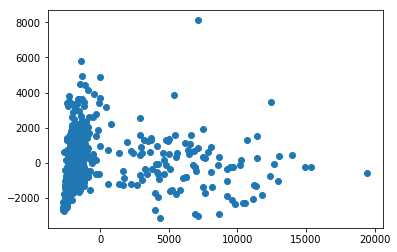

In [8]:
plt.scatter(data_trafo[:,0],data_trafo[:,1])
print(data_trafo)

In [ ]:
#bin the frequencies logarithmitically (higher frequencies are much lpwer -> bin them together)
#standardize (mean and unit variance feature
#go up to 150Hz
#since we bin emotions as well, do a) regression on percentage, b) classification at cutoff
#

In [ ]:
#what are the outstsanding points here?
time_idx=np.argwhere(data_trafo>2)[:,0]
#what is happening at these points?
#calculate back the time window:
idx=time_idx*pecog.wsize
print(idx)
#calculate from time windows to sampling points
start, stop = pecog.raw.time_as_index([idx[0]-5,idx[1]+5])
inter=pecog.raw.get_data(picks=range(0,40), start=start, stop=stop,reject_by_annotation=None, return_times=False)
print(inter.shape)

In [ ]:
print(pecog.curr_data)

In [ ]:
#pecog.vis_raw_data(idx[0]-5,idx[1]+5)
pecog.vis_raw_data(0,idx[1]+400)
pecog.vis_welch_data(50,time_idx[1]+200)

In [ ]:
good_data=pecog.calc_data_mat(idx[1]+100,idx[1]+400)
pecog.pca.fit(good_data)
good_data_trafo=pecog.pca.transform(good_data)
print(good_data_trafo.shape)
print(good_data.shape)


In [ ]:
print(good_data.shape)
print(good_data_trafo.shape)

In [ ]:
comps=pecog.pca.components_
print(pecog.raw.info['ch_names'][28])
print(comps.shape)
comps=comps.reshape((127,-1,2))
print(np.argmax(comps[:,:,1],axis=1))
#plt.plot(comps[5:,5:,0].T)
plt.plot(comps[:,:,1].T)
plt.ylim(-0.005,0.005)

In [ ]:
print(len(pecog.raw.info['chs']))

In [ ]:
#print(data_trafo)
plt.plot(good_data_trafo[:,0])
plt.plot(good_data_trafo[:,1])
#plt.xlim(-0.00001,0.00001)
#plt.ylim(-0.00001,0.00001)

#max(data_trafo[:,1])-min(data_trafo[:,1])

In [ ]:
##TEST STUFF
###functions for first insight. delete later
start, stop = pecog.raw.time_as_index([0, 51+pecog.wsize])
print(stop-start)
channel=pecog.raw.get_data(picks=[4,5],start=start, stop=stop,reject_by_annotation=None, return_times=False)
#data=np.squeeze(channel[0])

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(channel))
# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(channel[0,:]), 1.0/pecog.sfreq)
#welch method
fr,psd=signal.welch(channel,pecog.sfreq)

#throw away everything above 100Hz for now (and 0)
freqs=fft_freq[fft_freq<101][1:]
vals=fft_vals[:,fft_freq<101][:,1:]


plt.plot(fr,psd[0])
plt.plot(fr,psd[1])

#plt.plot(freqs,vals[1])
#plt.plot(freqs,vals[0])

#plt.plot(fft_freq[1:], fft_vals[1:])
#plt.xlabel('Frequency')
#plt.ylabel('Intensity')
#plt.show()
#plt.plot(freqs,vals)
#plt.xlabel('Frequency')
#plt.ylabel('Intensity')

#for 3D
# fig = pyplot.figure()
# ax = Axes3D(fig)

# ax.scatter(data_trafo[:,0],data_trafo[:,1],data_trafo[:,2],c='b')
# pyplot.show()